In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("resources/SpotifyFeatures.csv")

# View basic info
df.info()  # Check column types & missing values
df.head()  # Preview first few rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [2]:
songsearch = df[df['artist_name']=="Creed"]
songsearch.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
1320,Alternative,Creed,Higher,1ZozJfi8u9cO2Ob8KwiwNT,65,0.000051,0.459,316733,0.830,0.000140,D,0.206,-6.254,Major,0.0364,155.826,4/4,0.431
1332,Alternative,Creed,With Arms Wide Open,0eKyHwckh9vQb8ncZ2DXCs,61,0.004250,0.410,274800,0.539,0.000890,C,0.117,-8.412,Major,0.0302,138.852,4/4,0.141
1433,Alternative,Creed,One Last Breath,42T2QQv3xgBlpQxaSP7lnK,65,0.008410,0.386,238240,0.677,0.003660,D,0.341,-5.830,Major,0.0346,126.602,4/4,0.195
1453,Alternative,Creed,My Sacrifice,2VSbEXqs6NbNiZSTcHlIDR,66,0.000101,0.320,294600,0.880,0.000004,D,0.076,-6.035,Major,0.0504,146.349,4/4,0.257
1858,Alternative,Creed,My Own Prison,5vRPXm59z8ewWO6WiJHg3m,58,0.027700,0.505,298800,0.778,0.002750,A#,0.115,-4.778,Major,0.0398,140.493,4/4,0.284


#Preprocess Data & Model Training

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import difflib
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("resources/SpotifyFeatures.csv")

# Drop unnecessary columns
cols_to_drop = ["Unnamed: 0", "id", "release_date", "track_id"]
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

# Convert 'mode' to numeric (Major = 1, Minor = 0)
mode_mapping = {"Major": 1, "Minor": 0}
df["mode"] = df["mode"].map(mode_mapping)

# Convert 'key' to numeric mapping
key_mapping = {'C': 0, 'C#': 1, 'D': 2, 'D#': 3, 'E': 4, 'F': 5, 'F#': 6, 'G': 7, 'G#': 8, 'A': 9, 'A#': 10, 'B': 11}
df["key"] = df["key"].map(key_mapping)

# Drop rows with missing track names
df.dropna(subset=["track_name"], inplace=True)

# Work with a **sample subset** to optimize execution speed
df_sample = df.sample(5000, random_state=42)  # Reduce dataset for faster processing

# Select numeric features for scaling
numeric_features = ["danceability", "energy", "tempo", "acousticness", "instrumentalness", "valence", "loudness", "mode"]
X = df_sample[numeric_features].copy()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_features)



In [10]:
df.head() 

,genre,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0,0.611,0.389,99373,0.910,0.000,1,0.3460,-1.828,1,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),1,0.246,0.590,137373,0.737,0.000,6,0.1510,-5.559,0,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,3,0.952,0.663,170267,0.131,0.000,0,0.1030,-13.879,0,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0,0.703,0.240,152427,0.326,0.000,1,0.0985,-12.178,1,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,4,0.950,0.331,82625,0.225,0.123,5,0.2020,-21.150,1,0.0456,140.576,4/4,0.390


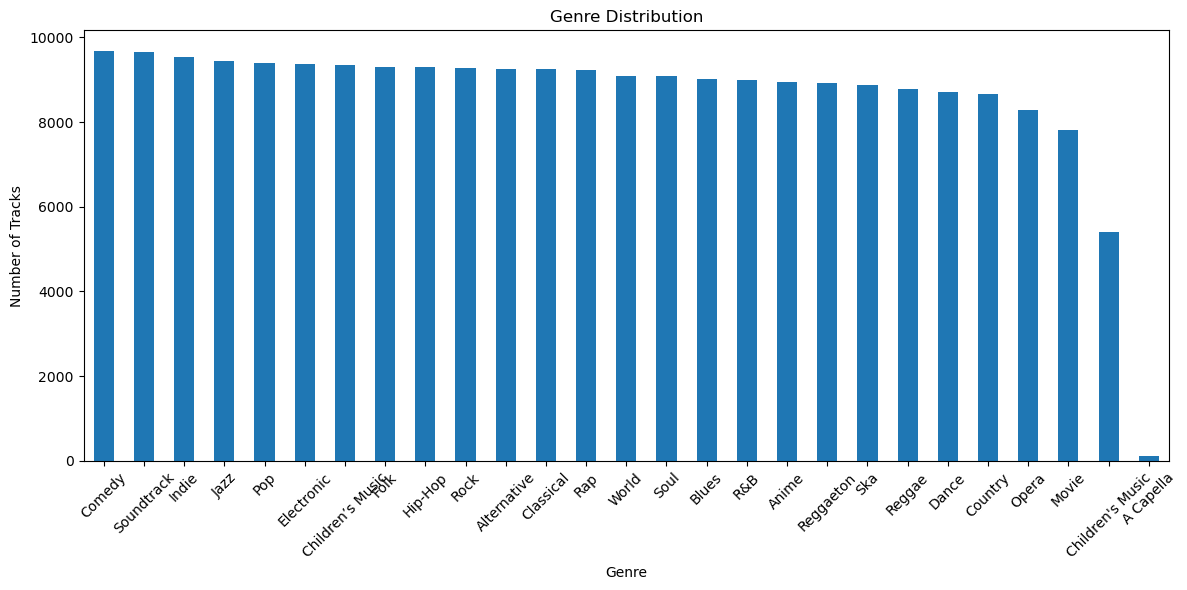

In [6]:
# Count occurrences of each genre
genre_counts = df['genre'].value_counts()

# Plot distribution of genres
plt.figure(figsize=(12, 6))
plot_1 = genre_counts.plot(kind='bar')
plot_1.set_title('Genre Distribution')
plot_1.set_xlabel('Genre')
plot_1.set_ylabel('Number of Tracks')
plot_1.set_xticklabels(plot_1.get_xticklabels(), rotation=45)
plt.tight_layout()

plt.show()

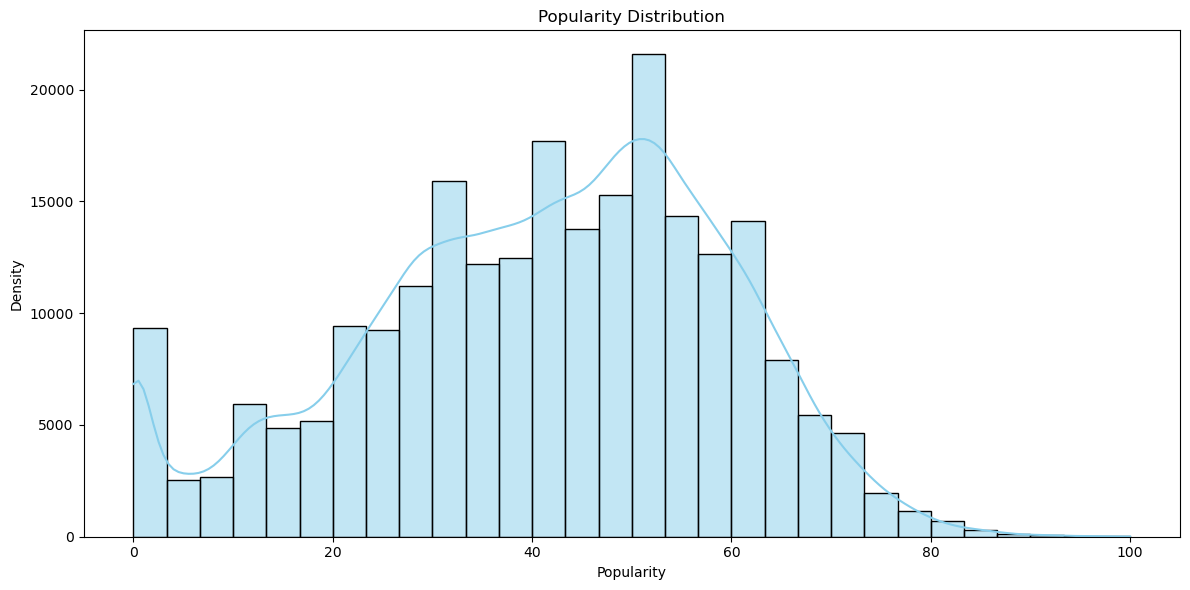

In [ ]:
import seaborn as sns
# Plot distribution of popularity
plt.figure(figsize=(12, 6))
plot_2 = sns.histplot(df['popularity'], bins=30, kde=True, color='skyblue')
plot_2.set_title('Popularity Distribution')
plot_2.set_xlabel('Popularity')
plot_2.set_ylabel('Density')

plt.tight_layout()
plt.show()
plt.savefig("Output/Pop_Dist.png")

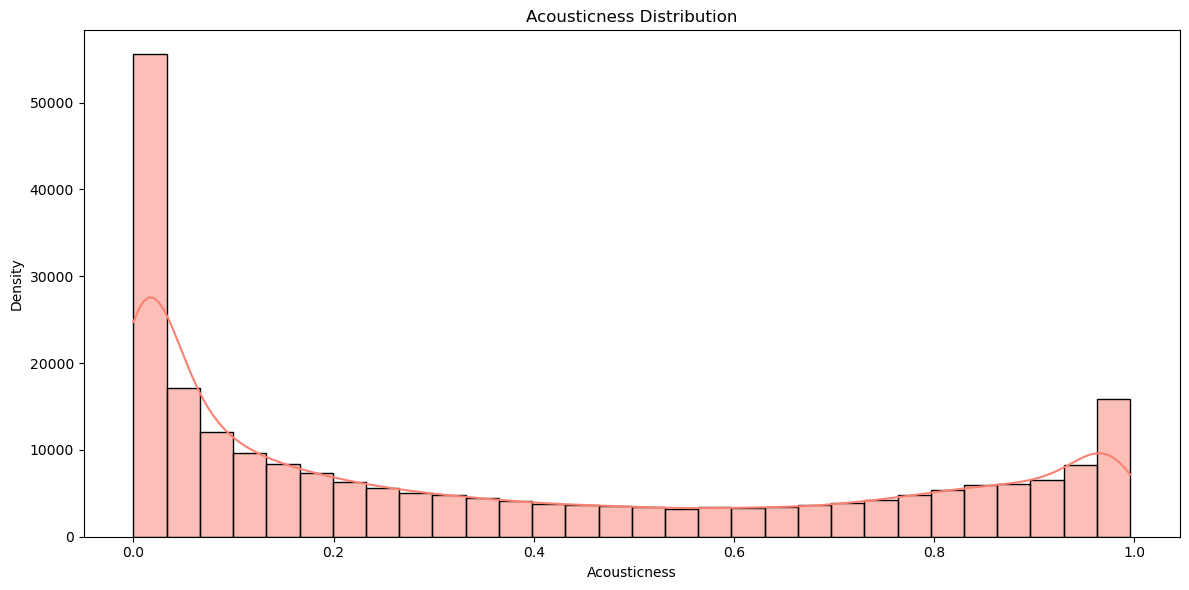

In [11]:
# Plot distribution of 'acousticness'
plt.figure(figsize=(12, 6))
plot_3 = sns.histplot(df['acousticness'], bins=30, kde=True, color='salmon')
plot_3.set_title('Acousticness Distribution')
plot_3.set_xlabel('Acousticness')
plot_3.set_ylabel('Density')

plt.tight_layout()
plt.show()

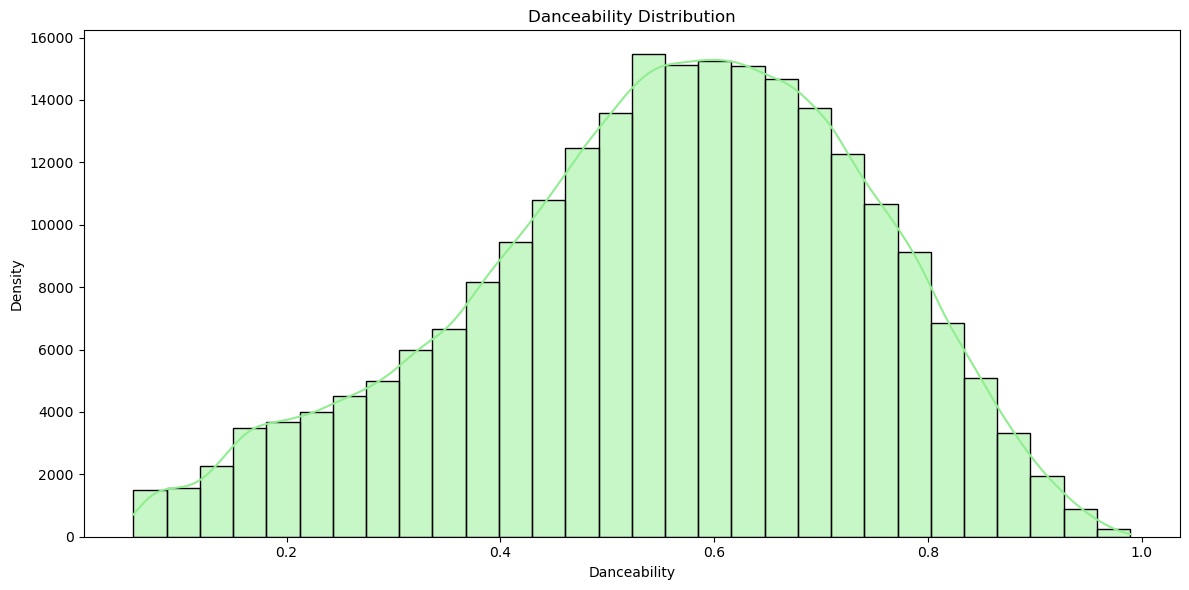

In [ ]:
# Plot distribution of 'danceability'
plt.figure(figsize=(12, 6))
plot_4 = sns.histplot(df['danceability'], bins=30, kde=True, color='lightgreen')
plot_4.set_title('Danceability Distribution')
plot_4.set_xlabel('Danceability')
plot_4.set_ylabel('Density')

plt.tight_layout()
plt.show()
plt.savefig("Output/Danceability_Dist.png")

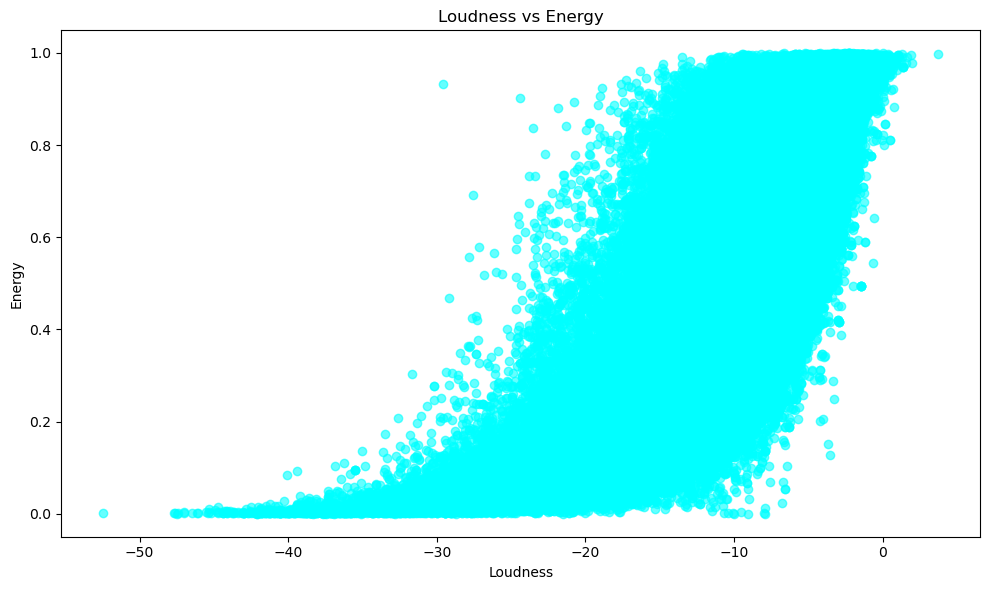

In [18]:
# Create scatter plot of loudness vs. energy
plt.figure(figsize=(10, 6))
plot_5 = plt.scatter(df['loudness'], df['energy'], alpha=0.6, color='cyan')
plt.title('Loudness vs Energy')
plt.xlabel('Loudness')
plt.ylabel('Energy')

plt.tight_layout()
plt.show()

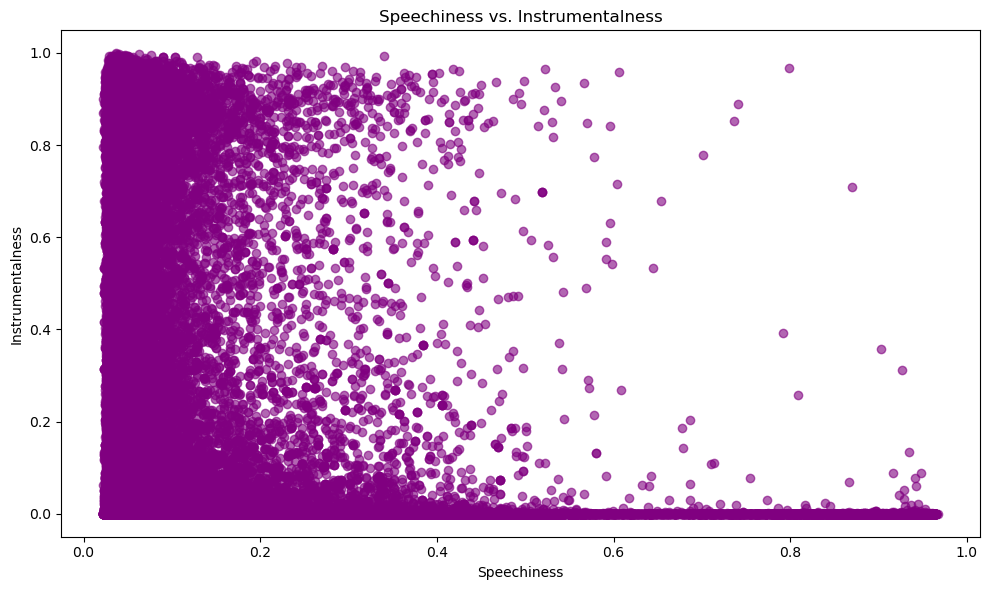

In [ ]:
# Create scatter plot of speechiness vs instrumentalness
plt.figure(figsize=(10, 6))
plot_6 = plt.scatter(df['speechiness'], df['instrumentalness'], alpha=0.6, color='purple')
plt.title('Speechiness vs. Instrumentalness')
plt.xlabel('Speechiness')
plt.ylabel('Instrumentalness')

plt.tight_layout()
plt.show()
plt.savefig("Output/Speechiness-V-Instrumentalness.png")

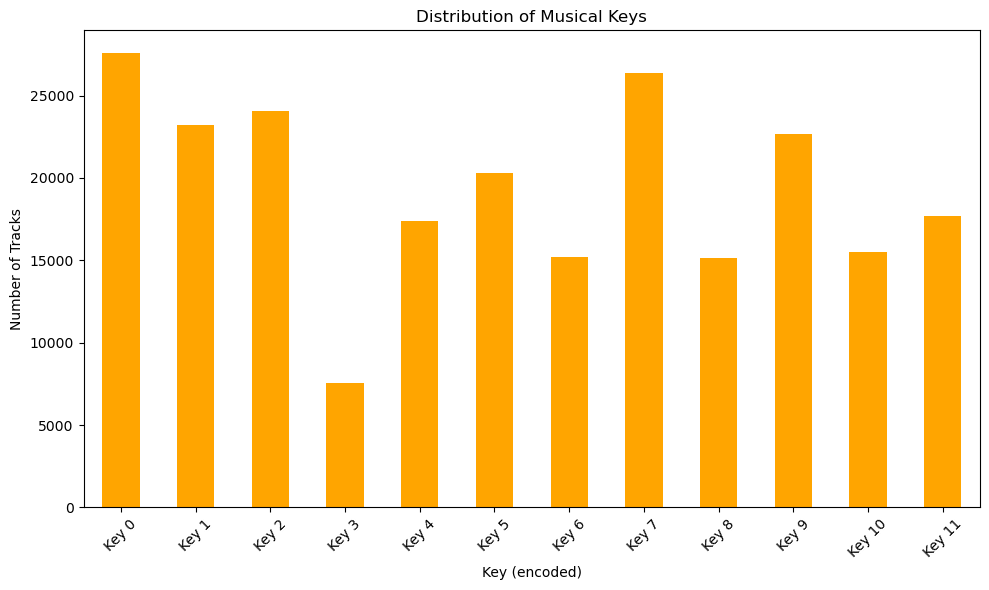

In [20]:
# Plot distribution of 'key' (assuming already encoded)
plt.figure(figsize=(10, 6))
plot_7 = df['key'].value_counts().sort_index().plot(kind='bar', color='orange')
plot_7.set_title('Distribution of Musical Keys')
plot_7.set_xlabel('Key (encoded)')
plot_7.set_ylabel('Number of Tracks')
plot_7.set_xticklabels([f'Key {i}' for i in range(12)], rotation=45)

plt.tight_layout()
plt.show()

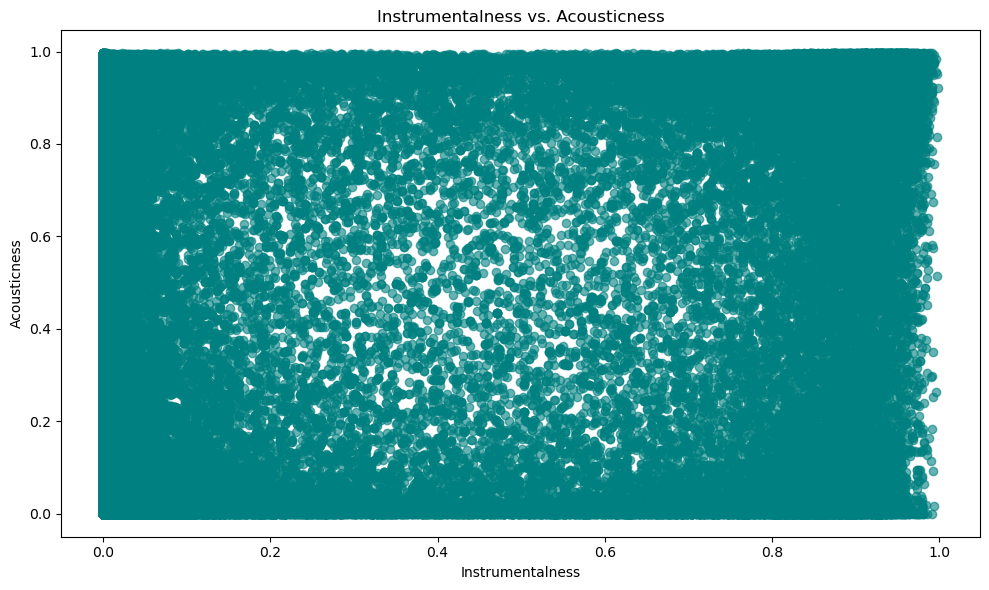

In [22]:
plt.figure(figsize=(10, 6))
plot_9 = plt.scatter(df['instrumentalness'], df['acousticness'], alpha=0.6, color='teal')
plt.title('Instrumentalness vs. Acousticness')
plt.xlabel('Instrumentalness')
plt.ylabel('Acousticness')

plt.tight_layout()
plt.show()

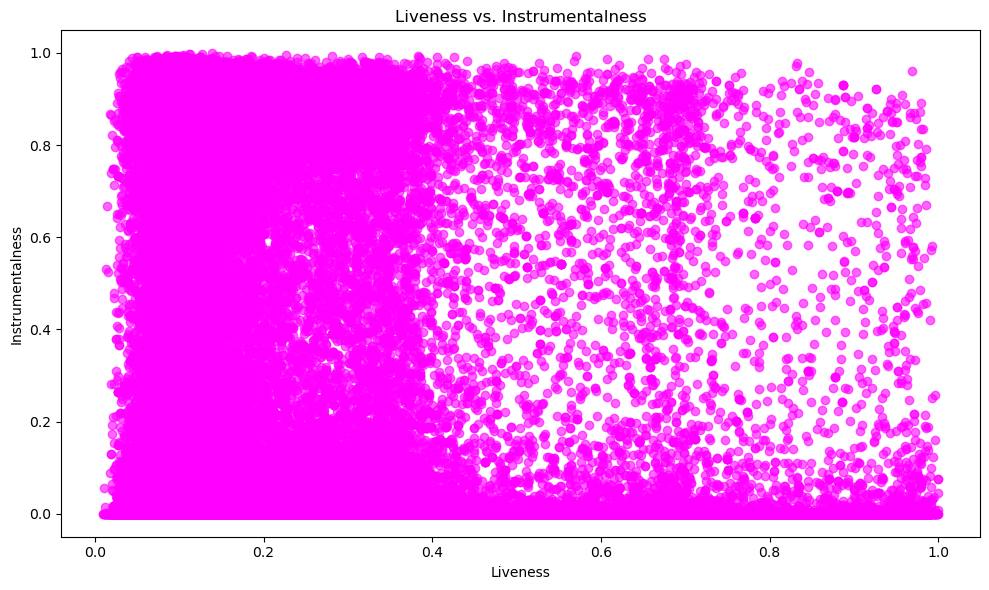

In [ ]:
# Create scatter plot of liveness vs. instrumentalness
plt.figure(figsize=(10, 6))
plot_8 = plt.scatter(df['liveness'], df['instrumentalness'], alpha=0.6, color='magenta')
plt.title('Liveness vs. Instrumentalness')
plt.xlabel('Liveness')
plt.ylabel('Instrumentalness')

plt.tight_layout()
plt.show()
plt.savefig("Output/Liveness-V-Instrumentalness")

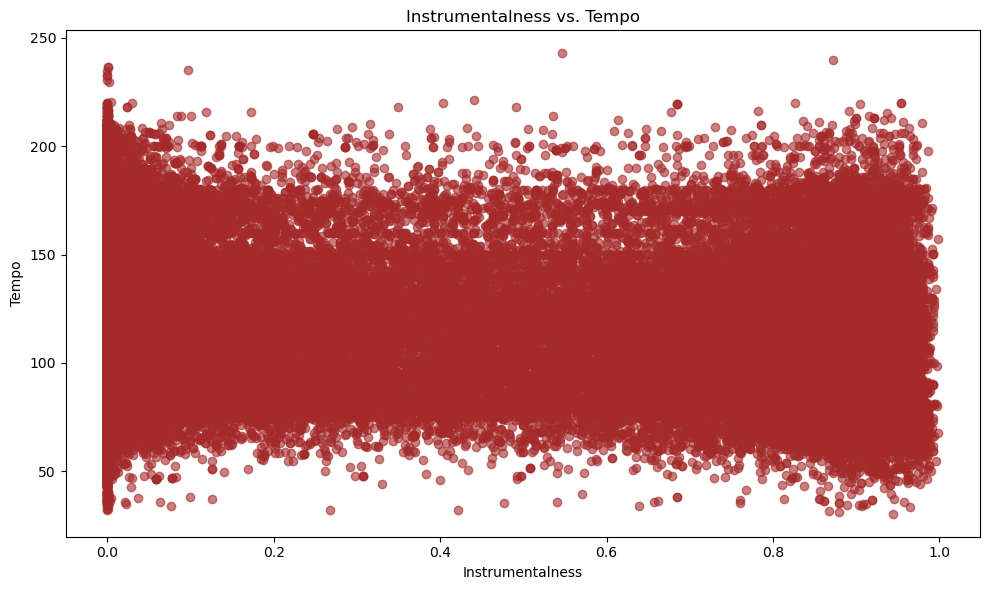

In [23]:
# Create scatter plot of instrumentalness vs. tempo
plt.figure(figsize=(10, 6))
plot_10 = plt.scatter(df['instrumentalness'], df['tempo'], alpha=0.6, color='brown')
plt.title('Instrumentalness vs. Tempo')
plt.xlabel('Instrumentalness')
plt.ylabel('Tempo')

plt.tight_layout()
plt.show()

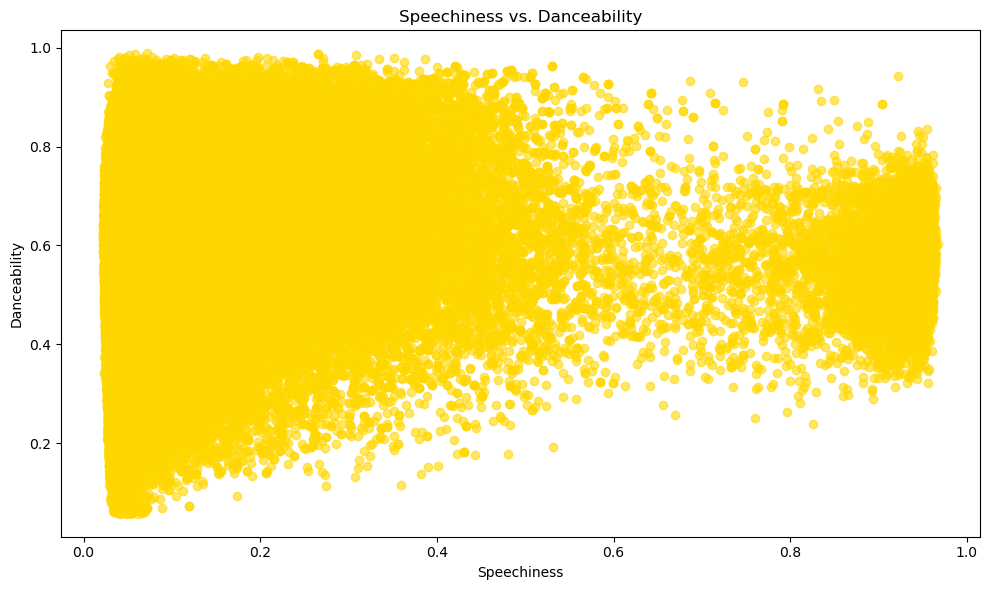

In [ ]:
# Create scatter plot of speechiness vs. danceability
plt.figure(figsize=(10, 6))
plot_11 = plt.scatter(df['speechiness'], df['danceability'], alpha=0.6, color='gold')
plt.title('Speechiness vs. Danceability')
plt.xlabel('Speechiness')
plt.ylabel('Danceability')

plt.tight_layout()
plt.show()
plt.savefig("Output/Speechiness-V-Danceability.png")

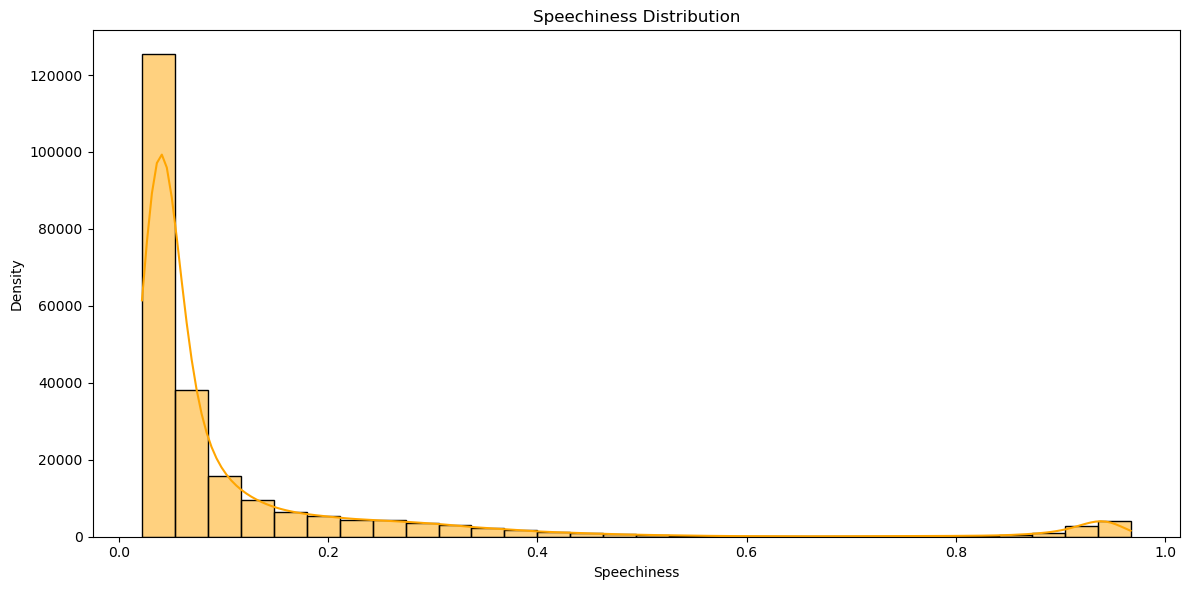

In [ ]:
# Plot distribution of speechiness
plt.figure(figsize=(12, 6))
plot_12 = sns.histplot(df['speechiness'], bins=30, kde=True, color='orange')
plot_12.set_title('Speechiness Distribution')
plot_12.set_xlabel('Speechiness')
plot_12.set_ylabel('Density')

plt.tight_layout()
plt.show()
plt.savefig("Output/Speechiness_Dist.png")

In [13]:
# Apply PCA for dimensionality reduction with optimized components
# PCA explained variance ratio shows how much information is retained after dimensionality reduction
pca = PCA(n_components=3)  # Fewer components for speed
X_pca = pca.fit_transform(X_scaled_df)
print(f"Explained Variance Ratio: {sum(pca.explained_variance_ratio_):.2f}")
# Create a DataFrame for PCA results
pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
# Add track names for reference
pca_df["track_name"] = df_sample["track_name"].values
# Add original index for reference
pca_df["original_index"] = df_sample.index.values
pca_df.head()

Explained Variance Ratio: 0.70


,PC1,PC2,PC3,track_name,original_index
0,1.170372,2.285558,1.071339,My Time's Comin',788
1,-3.696532,-0.203834,0.676260,The Magic Of Halloween - Soundtrack Reissue (2...,207108
2,0.901016,-0.014531,0.683670,Rosas Y Espinas,138643
3,1.298227,0.736009,0.599814,Endz - Original Mix,37164
4,-2.742562,-0.548763,0.823256,Glad to Be Unhappy (feat. John Mayer),177560


In [14]:
# Perform K-Means Clustering with optimized parameters
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_pca)

# Add cluster labels to DataFrame
df_sample["Cluster"] = labels



In [15]:
# Merge scaled features and key details into final DataFrame
df_scaled = pd.concat(
    [X_scaled_df.reset_index(drop=True), df_sample[["track_name", "artist_name", "genre", "Cluster"]].reset_index(drop=True)],
    axis=1
)



In [16]:
# Define a song recommendation function using cosine similarity
def recommend_song(input_song):
    if input_song not in df_scaled["track_name"].values:
        closest_match = find_closest_match(input_song)
        if closest_match:
            print(f"Closest match found: {closest_match}")
            input_song = closest_match
        else:
            return f"Song '{input_song}' not found."

    song_features = df_scaled.loc[df_scaled["track_name"] == input_song, numeric_features, ].values
    similarities = cosine_similarity(song_features,df_scaled[numeric_features])

    df_scaled["Similarity"] = similarities[0]
    recommendations = df_scaled.sort_values(by="Similarity", ascending=False).head(5)

    return recommendations[["track_name", "artist_name", "genre","danceability", "energy", "Similarity"]]



In [17]:
# Define a function to find closest matches for song names
def find_closest_match(input_song):
    song_list = df_scaled["track_name"].dropna().tolist()
    closest_match = difflib.get_close_matches(input_song, song_list, n=1, cutoff=0.6)
    return closest_match[0] if closest_match else None

# Test the recommendation function
print(recommend_song("Higher"))

              track_name          artist_name             genre  danceability  \
1929              Higher    The Hip Abduction            Reggae      0.269252   
4611            Lovesick            Mura Masa              Soul      0.571424   
2741        Way You Move     Slightly Stoopid            Reggae      0.463505   
691                 Ruby          Mat Kerekes  Children’s Music      0.258460   
3382  Rocky's Late Night  Albert Hammond, Jr.             Blues      0.339399   

        energy  Similarity  
1929  0.881445    1.000000  
4611  0.508952    0.968913  
2741  1.188655    0.961260  
691   0.935206    0.959717  
3382  0.355347    0.954841  
